<a href="https://colab.research.google.com/github/suptechlab/Data-Gymnasium/blob/main/notebooks/2021-05-27-Topic-Models-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling in Python


You developed a mobile app and want to figure out what your users are talking about in the app reviews. You have thousands of tweets mentioning your product and not enough time to read and digest all of them. Maybe you want to look at your emails from the last 5 years and figure out what you have spent your time on while reading and answering them.

If any of these use cases sounds familiar, you should learn about topic modeling! In this article, I will explore various topic modelling algorithms and approaches. You can also open it in Google Colab and apply on your dataset easily!



## Install the libraries

To start with, let's install three libraries:
- `datasets` will allow us to easily grab a bunch of texts to work with
- `sentence-transformers` will help us create text embeddings (more on that later)
- `bokeh` will help us with visualization

We will install these libraries and import the functions and classes we will need later on.

In [ ]:
!pip install -qq datasets
!pip install -Uqq sentence-transformers
!pip install -qq bokeh

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import sklearn.manifold
import numpy as np
import pandas as pd
import random
random.seed(42)
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import plasma, d3, Turbo256
from bokeh.plotting import figure
from bokeh.transform import transform
import bokeh.io
bokeh.io.output_notebook()

import bokeh.plotting as bpl
import bokeh.models as bmo
bpl.output_notebook()

## Grab the data

Topic modeling requires a bunch of texts. We don't need any labels! Let's grab an English subset of the public Amazon reviews dataset and test if we can get practical insights on the topics and themes represented in those reviews.

In [ ]:
dataset = load_dataset('amazon_reviews_multi', 'en')

Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


## First Look at the Data


Let's take a quick look at the data we'll be working with. Our dataset is a dictionary consisting of three parts: train, validation and test. Let's peek into the train set and put it into pandas dataframe to see how it's constructed.

In [ ]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [ ]:
df = pd.DataFrame(dataset['train'])
df.head()

,language,product_category,product_id,review_body,review_id,review_title,reviewer_id,stars
0,en,furniture,product_en_0740675,Arrived broken. Manufacturer defect. Two of th...,en_0964290,I'll spend twice the amount of time boxing up ...,reviewer_en_0342986,1
1,en,home_improvement,product_en_0440378,the cabinet dot were all detached from backing...,en_0690095,Not use able,reviewer_en_0133349,1
2,en,home,product_en_0399702,I received my first order of this product and ...,en_0311558,The product is junk.,reviewer_en_0152034,1
3,en,wireless,product_en_0444063,This product is a piece of shit. Do not buy. D...,en_0044972,Fucking waste of money,reviewer_en_0656967,1
4,en,pc,product_en_0139353,went through 3 in one day doesn't fit correct ...,en_0784379,bubble,reviewer_en_0757638,1


This is useful - we can see that the dataset consists of a number of atributes. We'll focus on the `review_body` and try to discover topics in those reviews, but the other attributes can help us to validate if we're stepping in a good direction. For example, we can compare how our topics correlate with the `product_category` attribute. Let's peek into the the categories just to see what we have in the dataset.

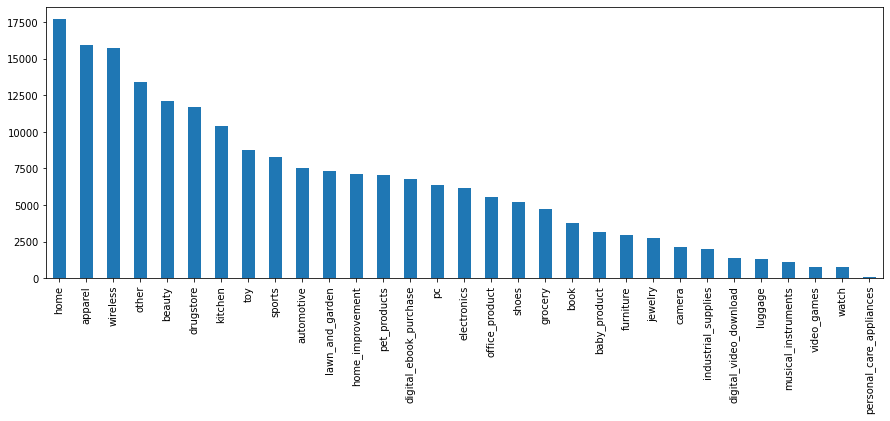

In [ ]:
df.product_category.value_counts().plot(kind='bar', figsize=(15,5));

How can we extract meaning from the `review_body` though? There are many ways of course. Rather than going bottom up from simple techniques such as key words, n-grams, tf-idf etc., let's jump straight into the concept of embedding.

### Embeddings

A key idea for machine learning is that of representations. Most algorithms can only work with numbers, so whatever we're dealing with - words, texts, images - we should represent with numbers. We are focusing on texts here, texts can represent many different things, so we also need many numbers - let's say 768 - for each text. We'll put these 768 numbers into vectors and use them to represent our texts. **These vectors are called embeddings**.

For the purpose of these article, we will not worry about where these embeddings come from, other than the fact we can produce them with the SentenceTransformer library. We will load a pretrained model (Distilbert) and use it to encode our texts.

### Dimensionality Reduction

768 numbers for each text is actually less meaningful to a normal person than a text, so how does this help? We can use some magic to reduce these 768 numbers to 2. These magic is called `t-SNE` and it's one of several dimensionality reduction techniques (for example `PCA` or `UMAP`). It tries to preserve the relative positions of points in a multidimensional space while mapping it to fewer dimensions. With 2 dimensions, we can actually plot these points (texts) on a chart! Let's do it!

Oh, we have 20.000 texts, so our chart can get really cluttered... Let's take a 1000 texts sample and use it instead.

In [ ]:
model = SentenceTransformer('stsb-distilbert-base')

In [ ]:
sample = df.sample(n=1000, random_state=42)
texts = sample.review_body.values.tolist()
categories = sample.product_category.values.tolist()

In [ ]:
embeddings = model.encode(texts)

In [ ]:
out = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings)

### Visualization with bokeh

Bokeh is a nice tool that allows us to create interactive charts. We'll use it to create a scatter plot where each text is placed according to the *meaning dimension*. Additionally, we're color each dot to indicate which category it comes from. We can hover over the chart and see the text/category associated with each dot.

In [ ]:
clrs = random.sample(Turbo256, len(set(categories)), )
color_map = bmo.CategoricalColorMapper(factors=list(set(categories)), palette=clrs)

In [ ]:
list_x = out[:,0]
list_y = out[:,1]
desc = texts

source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc, cat=categories))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('desc', '@desc'),
    ('cat', '@cat')
])

p = figure(plot_width=1200, plot_height=600, tools=[hover], title="First Look at the Data")
p.circle('x', 'y', size=10, source=source, fill_color=transform('cat', color_map),)
bpl.show(p)

In [ ]:
#hide_input

# this cell will fail if you run it in colab, it's a workaround to display the chart in the blog
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.display import display, HTML

html = file_html(p, CDN, "First Look at the Data")
HTML(html)

Looks interesting! If you hover over the distinct clusters on the chart, you should be able to recognize common topics. Some of these topics are related to a single category, some of them are shared across categories. What topics can you find in the chart?

## Discovering Topics with BERTopic

Looking at the chart above, we can get a sense for some of the topics in our corpus, but it doesn't solve our problem yet. It would require lots of time to review the chart in detail, find clusters, and label them. How can we automate this process?

BERTopic is one of the methods to achieve that. It depends on sentence embeddings and clustering algorithms, as well as dimensionality reduction to produce clusters of documents (topics). Let's if we can get some good insights with this approach.

In [ ]:
!pip install bertopic -qq

In [ ]:
from bertopic import BERTopic

In [ ]:
model = BERTopic(language="english")
topics, probs = model.fit_transform(texts)

In [ ]:
len(topics), len(set(topics))

(1000, 16)

We've run the algorithm on our 1000 texts sample, and it identified 16 topics in this corpus. Let's see if we can learn something more about those topics!

In [ ]:
model.get_topic_freq().head(15)

,Topic,Count
0,-1,451
1,11,104
2,9,97
3,14,61
4,10,43
5,1,42
6,7,28
7,8,28
8,0,26
9,13,22


Wow, there's quite a lot of outliers here, represented by topic -1, almost half of the dataset! Let's take a look at one of the topics from this dataset.

In [ ]:
model.get_topic(1)

[('size', 0.05050109336233438),
 ('fit', 0.026139678912211962),
 ('could', 0.025590393661103304),
 ('top', 0.025448458979747752),
 ('ordered', 0.02355394098054413),
 ('dress', 0.022519132135764744),
 ('larger', 0.020384763234235534),
 ('zipper', 0.019640993684217505),
 ('too', 0.01934745458460365),
 ('all', 0.019074915582195817)]

What we typically get with topic modelling is key words associated with each topic. In the case above, we can see key words associated with sizes: *size, fit, larger*. Let's take a look at some texts associated with this topic to confirm our intuition.

In [ ]:
ex_ind = [i for i, x in enumerate(topics) if x == 1]
ex_txt = [x for i, x in enumerate(texts) if i in ex_ind]
for t in ex_txt[:10]: print(t)

Really cute mug. I would have given 5 stars if it were a bit bigger.
Not the size I hoped for but that could be partly my fault. It did come in a very nice gift bag with the brand name on it but I just wish that it was a bead or two larger. Otherwise this is a great gift for someone with a petite wrist.
Its o.k. but not as thick as another brand I previously used. I think the other brand lasted longer in my hair for the day.
I wish I could give 5 stars. As far as the glasses go, I absolutely love them. But three glasses arrived completely shattered
The size was off, I usually wear a lrg. or x-lrg. But this was snug I wanted to order larger but was sold out.
The top was a bit tight and I'm a 36 B. I got a medium. I prob would still wear top but underboob is inevitable since the straps are not adjustable. Otherwise the top was cute. Bottoms fit weird and where the strappy parts are on each side the inner lining (tan/white material) showed no matter what and looked super odd. Not cute at 

Indeed, most of these texts talk about sizes! Looks like the model is onto something!


What if we overlay the topics discovered here with our initial scatter plot? Let's try it! Now, instead of categories, we will color the dots according to the topic assigned by BERTopic algorithm.

In [ ]:
topic_words = ['-1: outlier']
for i in range(len(set(topics))-1):
  tpc = model.get_topic(i)[:7]
  words = [x[0] for x in tpc]
  tw = ' '.join([str(i) + ':'] + words)
  topic_words.append(tw)

In [ ]:
exp_topics = [topic_words[x+1] for x in topics]

In [ ]:
clrs = random.sample(Turbo256, len(set(topics)))
color_map = bmo.CategoricalColorMapper(factors=topic_words, palette=clrs)

In [ ]:
list_x = out[:,0]
list_y = out[:,1]
desc = texts

source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc, topic=exp_topics))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ('desc', '@desc'),
    ('topic', '@topic')
])

p = figure(plot_width=1200, plot_height=600, tools=[hover], title="Test")
p.circle('x', 'y', size=10, source=source,
         fill_color=transform('topic', color_map),
         # legend='topic'
)
# p.legend.location = "top_left"
# p.legend.click_policy="hide"

bpl.show(p)

In [ ]:
#hide_input

# this cell will fail if you run it in colab, it's a workaround to display the chart in the blog
html = file_html(p, CDN, "First Look at the Data")
HTML(html)

In this visual, the topics are clustered together - which makes sense, because the method for creating visual and topics is consistent. Interestingly, when looking at clusters of outliers that are located near each other in the chart, we can see common theme - I wonder why these were tagged as outliers?

# LDA with Mallet

Let's now turn to a classic approach - LDA, Latent Dirichlet Allocation. We will not review the theory or the inner workings of this algorithm here. The key difference vs. BERTopic is that each text (document) is considered to be a composition of topics. We don't cluster documents into topics, but instead discover abstract topics that are represented in a document corpus. For each document, we get the probability distribution over these topics.

Let's imagine we have discovered three topics: sports, data science, competition.

A document that is about data science competition might have the following distribution: *sports: 0.05, data science: 0.5, competition: 0.045*.

A document that talks about world championship in cricket migth have the following distribution instead: *sports: 0.54, data science: 0.01, competition: 0.45*.

There seem to be many implementations of the LDA algorithm, and some of them result in significantly worse results. It also seems that the Mallet implementation is considered one of the best ones, so we will use it here.

To speed things up, I will use the first 10.000 reviews for topic modeling. I will only display 1000 reviews in the t-sne chart.

## Imports and installation

In [ ]:
!pip install -Uqq gensim==3.8.3

     |████████████████████████████████| 24.2MB 143kB/s 


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
!wget -q http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -qq mallet-2.0.8.zip

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this

In [ ]:
def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)

    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)

    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

## Topic modelling with LDA

LDA requires some careful parameter choices to work properly. These seem to be expecially relevant:
- number of topics
- stop words list
- alpha parameter, which roughly determines how many topics correspond to a single document

In [ ]:
# texts_lda = [dataset['train'][i]['review_body'] for i in range(10000)]

In [ ]:
doc_clean = preprocess_data(texts,{})
dictionary, doc_term_matrix = prepare_corpus(doc_clean)

In [ ]:
number_of_topics=30 # adjust this to alter the number of topics
words=10 #adjust this to alter the number of words output for the topic below

In [ ]:
ldamallet = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, alpha=10)

In [ ]:
topic_words = ldamallet.show_topics(num_topics=number_of_topics,num_words=5)
topic_words = [x[1] for x in topic_words]

In [ ]:
topic_words = []
for i in range(number_of_topics):
  tpc = ldamallet.show_topic(i, topn=7, num_words=None)
  words = [x[0] for x in tpc]
  tw = ' '.join([str(i) + ':'] + words)
  topic_words.append(tw)

In [ ]:
topic_words

['0: case small love feels design bit camera',
 '1: perfect started fall heavy weight quickly feet',
 '2: nice day box gift looked purchased shoe',
 '3: 2 3 5 stars 1 4 weeks',
 '4: work bought make fine cut pump job',
 '5: broke side soft beautiful ring long bottom',
 '6: bag product picture package show guess happy',
 '7: hard money working lot worth worked things',
 '8: color light colors white loves lights daughter',
 '9: water plastic open air hold inside difficult',
 '10: size fit wear ordered order comfortable big',
 '11: put easy bought left times piece face',
 '12: arrived nice pieces broken returned completely thin',
 '13: quality made work easily poor fits low',
 '14: book love great pages missing family star',
 '15: great purchase cover screen purchased recommended replace',
 '16: great works recommend lots price smells awesome',
 '17: product bad month disappointed reason sound needed',
 '18: buy review year frame support difficult idea',
 '19: good fit bit brand fine watc

In [ ]:
topics_docs = list()
for m in ldamallet[doc_term_matrix[:1000]]:
    topics_docs.append(m)

In [ ]:
x = np.array(topics_docs[:1000])
y = np.delete(x,0,axis=2)
y = y.squeeze()

In [ ]:
best_topics = np.argmax(y, axis=1)
topics = list(best_topics)
topics = [topic_words[x] for x in topics]

In [ ]:
# up to 20 colors:
# palette = d3['Category20'][number_of_topics]
clrs = random.sample(Turbo256, number_of_topics)
color_map = bmo.CategoricalColorMapper(factors=topic_words, palette=clrs)

In [ ]:
list_x = out[:,0]
list_y = out[:,1]
desc = texts

source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc, topic=topics))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ('desc', '@desc'),
    ('topic', '@topic')
])

p = figure(plot_width=1200, plot_height=600, tools=[hover], title="Test")
p.circle('x', 'y', size=10, source=source,
         fill_color=transform('topic', color_map),
         # legend='topic'
)
# p.legend.location = "top_left"
# p.legend.click_policy="hide"

bpl.show(p)

In [ ]:
#hide_input

# this cell will fail if you run it in colab, it's a workaround to display the chart in the blog
html = file_html(p, CDN, "First Look at the Data")
HTML(html)

Looking at the chart above, it seems that the topics identified by LDA re not necessarily close to each other on the chart. We know that the chart should align well with topics identified by SentenceBert embeddings, so this confirms that both approaches are complementary and can result in a different set of topics.

My intuition is that BERTopic should work better for shorter documents, that are more likely to represent a single topic, while LDA may handle better longer texts that are likely a combination of topics. Both can offer some good insights into our documents, so it makes sense to try both!

Let's also look at the LDA topics visualizations through the PyLDAVis library.

## PyLDAVis charts

In [ ]:
gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [ ]:
!pip install -Uqq pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 6.7MB/s 


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(gensimmodel, doc_term_matrix, dictionary)
p

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.033064  0.021397       1        1  4.191545
17     0.128336  0.108840       2        1  3.559570
9     -0.006167  0.027536       3        1  3.502411
4     -0.066855 -0.107635       4        1  3.497698
25    -0.004104 -0.016268       5        1  3.481363
8      0.059137  0.086976       6        1  3.431855
10     0.111926 -0.091800       7        1  3.427406
24     0.060590 -0.046919       8        1  3.426148
11    -0.068446 -0.011198       9        1  3.425725
1     -0.022948  0.031617      10        1  3.420810
13     0.008262 -0.207324      11        1  3.415882
26     0.120201  0.024207      12        1  3.401144
22    -0.140157  0.043443      13        1  3.391451
14    -0.260760  0.080347      14        1  3.382819
7      0.063558  0.058842      15        1  3.360539
28    -0.064258 -0.313962      16        1  3.343257
5      0.074575 -0.076467      17        1  3.326888
23     0.023530  0.095291      18        1  3.302026
20     0.018358 -0.057340      19        1  3.278284
6      0.066188  0.075432      20        1  3.254083
29     0.086900 -0.017534      21        1  3.226927
21     0.169105  0.113699      22        1  3.223150
18     0.045370  0.049566      23        1  3.222646
19     0.003392 -0.292542      24        1  3.173020
27     0.101861  0.063238      25        1  3.170938
0     -0.040598 -0.071499      26        1  3.146142
16    -0.349907  0.070157      27        1  3.072813
2      0.024143  0.119865      28        1  3.046334
15    -0.271561  0.114912      29        1  3.035643
12     0.097266  0.125124      30        1  2.861482, topic_info=         Term        Freq       Total Category  logprob  loglift
72      great  221.000000  221.000000  Default  30.0000  30.0000
57       good  187.000000  187.000000  Default  29.0000  29.0000
168   product  171.000000  171.000000  Default  28.0000  28.0000
131      work  123.000000  123.000000  Default  27.0000  27.0000
61       size   92.000000   92.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
142  flexible    1.457466   10.592467  Topic30  -5.3566   1.5704
195     wrong    1.457466   24.313416  Topic30  -5.3566   0.7395
88    picture    1.457466   33.871201  Topic30  -5.3566   0.4080
197   ordered    1.457466   63.188502  Topic30  -5.3566  -0.2156
180      love    1.457466   95.266850  Topic30  -5.3566  -0.6262

[996 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
41        1  1.002160      1
379       5  0.114266     10
379      13  0.742730     10
379      20  0.171399     10
156      20  0.842395     12
...     ...       ...    ...
195      18  0.945980  wrong
195      30  0.041130  wrong
334      18  0.508327   year
334      23  0.484121   year
504       5  1.018215  years

[979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 18, 10, 5, 26, 9, 11, 25, 12, 2, 14, 27, 23, 15, 8, 29, 6, 24, 21, 7, 30, 22, 19, 20, 28, 1, 17, 3, 16, 13])

# Further Research

Below you can find links to some additional materials, research and tools related to topic modeling.

Top2Vec
- https://github.com/ddangelov/Top2Vec

Topic modeling in embedding spaces
- https://www.mitpressjournals.org/doi/full/10.1162/tacl_a_00325

The Dynamic Embedded Topic Model
- evolution of topics over time
- https://arxiv.org/pdf/1907.05545.pdf

TopicScan (NMF)
- https://github.com/derekgreene/topicscan

Topic model evaluation
- https://www.aclweb.org/anthology/E14-1056.pdf

Improving Neural Topic Models using Knowledge Distillation
- https://www.aclweb.org/anthology/2020.emnlp-main.137.pdf
- https://twitter.com/miserlis_/status/1305893876767612929
- https://github.com/ahoho/kd-topic-models

Neural Topic Modeling by Incorporating Document Relationship Graph
- Applying Graph NN to topic modeling
- https://www.aclweb.org/anthology/2020.emnlp-main.310.pdf

Weakly-Supervised Aspect-Based Sentiment Analysis via Joint Aspect-Sentiment Topic Embedding
- unsupervised combination of topic modeling and and aspect-based sentiment tagging
- https://github.com/teapot123/JASen  
- https://arxiv.org/pdf/2010.06705v1.pdf

Tired of Topic Models? Clusters of Pretrained Word Embeddings Make for Fast and Good Topics too!
- Similar to top2vec?
- https://arxiv.org/pdf/2004.14914v2.pdf
- https://github.com/adalmia96/Cluster-Analysis

Cross-lingual Contextualized Topic Models with Zero-shot Learning
- model learns topics in one language and predicts them for documents in another language
- https://arxiv.org/pdf/2004.07737v1.pdf

Pre-training is a Hot Topic: Contextualized Document Embeddings Improve Topic Coherence
- Another variation on neural topic modeling
- https://arxiv.org/pdf/2004.03974v1.pdf

Familia: A Configurable Topic Modeling Framework for Industrial Text Engineering
- Baidu’s framework for topic modeling and overview of use cases
- https://arxiv.org/pdf/1808.03733v2.pdf

Aspect Sentiment Model for Micro Reviews
- https://arxiv.org/pdf/1806.05499v1.pdf

Studying the History of Ideas Using Topic Models
- nice application of topic models by jurafsky, manning - get inspiration
- https://web.stanford.edu/~jurafsky/hallemnlp08.pdf

CoRel: Seed-Guided Topical Taxonomy Construction by Concept Learning and Relation Transferring
- User inputs a partial taxonomy, and CoRel extracts a more complete topical taxonomy based on user-interested aspect and relation, with each node represented by a cluster of words.
- https://arxiv.org/pdf/2010.06714.pdf
